<a href="https://colab.research.google.com/github/PedroDS4/Identificacao_de_sistemas_nao_lineares/blob/main/Non_Linear_System_identification_study_Pedro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Identificação de Sistemas Não Lineares**
Os sistemas lineares estão presentes em muitos campos de estudo, e muitas vezes eles são assumidos mesmo em modelos não lineares, para simplificação e aplicação de alguns tipos de modelagem, como a modelagem de Laplace ou de fourier.

Os sisteams lineares são caracterizados desse jeito, porque a equação diferencial que rege a dinâmica do sistema tem coeficientes constantes, e assim a saída do sistema pode ser modelada como a convolução da entrada com a resposta ao impulso do mesmo.


Porém, nem sempre a assunção de um sistema ser linear é verdadeira, assim, as vezes é preciso capturar a não linearidade e suas características para que uma precisão seja alcançada para determinada aplicação.


Nesse contexto, a identificação de sistemas não lineares entra, e com ela, é possível, utilizando aprendizado de máquina, capturar a dinâmica não linear de um sistema.


Considere um sistema dada pela equação

$$
\ddot{y}(t) = a_1 \dot{y}(t) + a_0 y(t) + x(t)  
$$

ou ainda em forma de equação de diferenças, temos

$$
y[k+2] = a_1 y[k+1] + a_0 y[k] + x[k]
$$

se os coeficientes $a_1$ e $a_0$ são constantes, o sistema é linear, porém, uma regra geral pra sistemas não lineares pode ser da forma

$$
y[k] = f(y[k-1],y[k-2],x[k],x[k-1])
$$

aqui consideramos causalidade e também que dependem de poucos atrasos no tempo.

Nomeando ainda, todas as variáveis dependentes como uma só, na forma matricial dada por

$$
\mathbf{U}[k] = (y[k-1],y[k-2],x[k],x[k-1])
$$

então o modelo se torna

$$
y[k] = f(\mathbf{U}[k])
$$

Então utilizaremos uma abordagem com funções de base radial, para estimar a não linearidade do sistema, temos então que a saída em função do tempo se torna

$$
y[k] = \sum_{i = 0}^{N_c}  w_i \Phi({ \frac{-||\mathbf{U}[k] - \mathbf{Z}_i||_2^2}{2 \sigma_i^2} })
$$

onde $N_c$ representa o número de funções de base, $\mathbf{Z}$ representa o vetor de centros, $\sigma_i^2$ representa a variância de cada componente da base.


Podemos então fazer um treinamento supervisionado com alguns dados para o sistema, e fazê-lo aprender a dinâmica do sistema utilizando algum algoritmo de otimização para ajustar os pesos $\alpha_j$, e então validar com outra entrada e saída.

A forma vetorial da equação de ajuste é dada por

$$
\mathbf{y} = \mathbf{\Phi} \mathbf{w}
$$

onde $\mathbf{w}$ é o vetor de pesos da rede, e a lei de formação da matriz $\mathbf{\Phi}$ é:

$$
{\Phi}[k,i] = \Phi_{\sigma_i}(\mathbf{U}[k] - \mathbf{Z}_i)
$$

o vetor de pesos ótimo para pode ser encontrado pela solução de mínimos quadrados, então podemos usá-la para fazer o treinamento, assim definimos a função de custo

$$
J(\mathbf{w}) = \frac{1}{2N}||\mathbf{y} - \mathbf{\Phi} \mathbf{w}||_2^2
$$

o ponto de mínimo dessa função é

$$
\mathbf{w} = ( \mathbf{\Phi}^T  \mathbf{\Phi})^{-1}  \mathbf{\Phi}^T \mathbf{y}
$$

assim podemos reconstruir finalmente a saída do sistema como

$$
\mathbf{y}_{est} = \mathbf{\Phi}(\mathbf{U}) \mathbf{w}_{otm}
$$

a função de base escolhida para as implementações foi a inversa multiquadratica, dada por

$$
\phi_{\sigma}(\mathbf{r}) = \frac{1}{\sqrt{1 + \frac{||\mathbf{r}||_2^2}{\sigma^2}}}
$$

In [1]:
##**Funções**

def f(u, noise_std=0.0):
    """
    Implementa o sistema não linear discreto do artigo:
        y[t+1] = (0.3*y[t] + 0.6*y[t-1] + 0.6*sin(pi*u[t]) + 0.4*sin(3*pi*u[t]))/5.5 + e[t]
    """
    N = len(u)
    y = np.zeros(N)

    # Definir ruído
    noise = np.random.normal(0, noise_std, N)

    # inicialização dos atrasos
    y[0] = 0
    y[1] = 0

    for t in range(1, N-1):
        y[t+1] = (0.3*y[t]
                  + 0.6*y[t-1]
                  + 0.6*np.sin(np.pi*u[t])
                  + 0.4*np.sin(3*np.pi*u[t]))/5.5 \
                  + noise[t]
    return y



def f_pendulo(x,h = 0.01):
  g = 10
  l = 0.1
  N = len(x)
  y = np.zeros(N)
  p = np.zeros(N)

  y[0] = 0.01
  p[0] = 0

  for i in range(0,N-1):
      p[i+1] = p[i] + h*(-g/l*np.sin(y[i]) + x[i])
      y[i+1] = y[i] + h*( p[i] )

  return y





def U_matrix(x, y, x_lags, y_lags):
  N = len(x)
  M_1 = len(x_lags)
  M_2 = len(y_lags)
  U = np.zeros((int(M_1+M_2),N))

  for j in range(M_2):
    lag_y = y_lags[j]
    if lag_y == 0:
      U[j,:] = y
    else:
      U[j,:] = np.concatenate( (np.zeros(lag_y), y[0:-lag_y]) )

  for i in range(M_1):
    lag_x = x_lags[i]
    if lag_x == 0:
      U[i+M_2,:] = x
    else:
      U[i+M_2,:] = np.concatenate( (np.zeros(lag_x), x[0:-lag_x]) )


  return U.T



def phi_gaussiana(u, c, sigma):
  phi = np.exp(-(1/(2*(sigma**2)))*la.norm(u-c)**2)
  return phi


def phi_inv_multiquadrica(u, c, sigma):
  phi = 1/np.sqrt(1 + (la.norm(u-c)/sigma)**2)
  return phi


def Phi(U, c, sigma, phi_rad):
  # U: Matriz com as dependências do sistema
  # N = len(U[0,:])
  N = U.shape[0]
  M = len(c)


  Phi1 = np.zeros(shape = (N,M))

  for i in range(N):
    for j in range(M):
      Phi1[i,j] = phi_rad(U[i],c[j], sigma[j])

  return Phi1



##**Sistema não Linear: Exemplo 2**
O sistema não linear descrito pela equação de diferenças

$$
y[k+1] = 0.3y[k] + 0.6y[k-1] + 0.6 sin(πu[k]) +\frac{0.4 sin(3πu[k])}{5.5} + e[k]
$$

é descrito no artigo [1], onde $e[k]$ representa um ruído aleatório, que nesse caso será modelado como ruído AWGN.



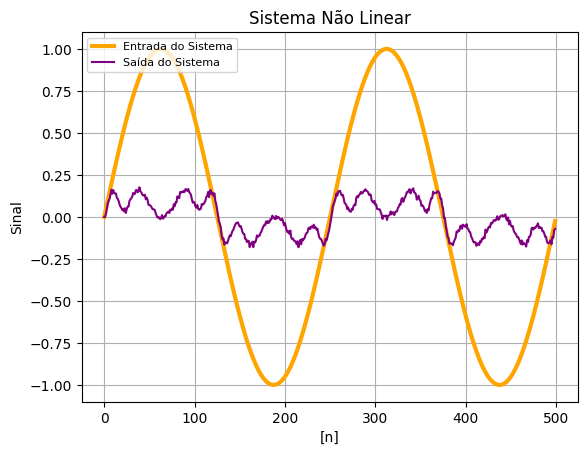

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la



N = 1000//2
n = np.arange(0,N,1)
y = np.zeros(N)



rng = np.random.default_rng(600)
w = rng.normal(0, 1, N)

# filtro FIR simples
h = np.ones(N)/20
# x = np.convolve(w, h, mode='same')

x = np.sin(2*np.pi*n/250)




h = 0.01

y_1 = f(x, noise_std = 0.01)


plt.plot(n, x, c = 'orange', label = 'Entrada do Sistema', linewidth = 3)
plt.plot(n, y_1, color = 'purple',label = 'Saída do Sistema')
plt.xlabel('[n]')
plt.ylabel('Sinal')
plt.title('Sistema Não Linear')
plt.grid()
plt.legend(loc='upper left', fontsize = 8)
plt.show()


[-9.99921044e-01 -9.16594291e-01 -8.33267537e-01 -7.49940783e-01
 -6.66614029e-01 -5.83287276e-01 -4.99960522e-01 -4.16633768e-01
 -3.33307015e-01 -2.49980261e-01 -1.66653507e-01 -8.33267537e-02
  1.11022302e-16  8.33267537e-02  1.66653507e-01  2.49980261e-01
  3.33307015e-01  4.16633768e-01  4.99960522e-01  5.83287276e-01
  6.66614029e-01  7.49940783e-01  8.33267537e-01  9.16594291e-01
  9.99921044e-01]


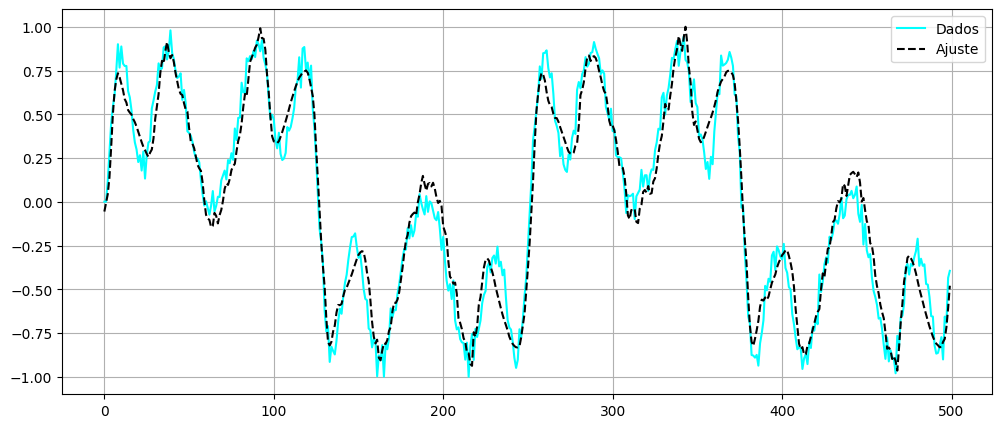

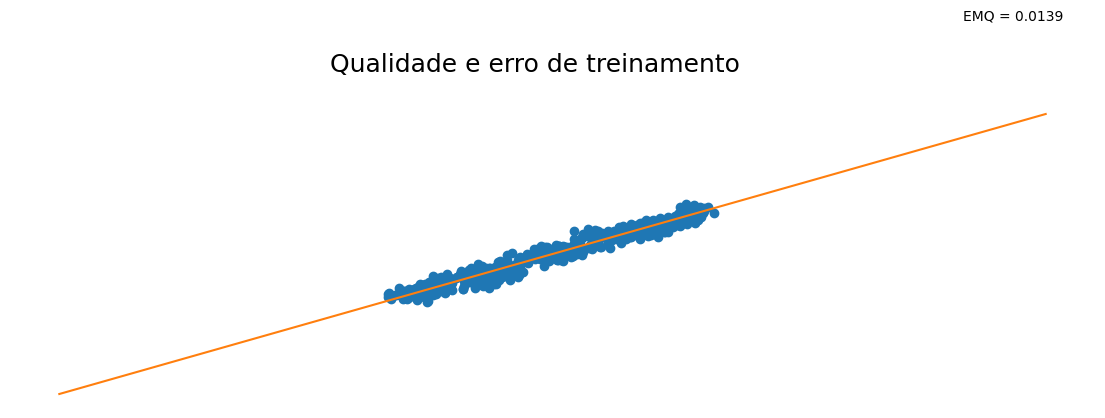

In [3]:
x_1 = x
# c = np.linspace(0,1,8)  # [0,0.125,0.25,0.375,0.5,0.625,0.75,0.875,1]
c = np.linspace(np.min(x_1),np.max(x_1), 25)
M = len(c)
N = len(y_1)
#sigma = 2
print(c)
sigma = 1*np.ones(M)


U_1 = U_matrix(x_1, y_1, np.array([0]), np.array([1,2]))
Phi1 = Phi(U_1, c, sigma, phi_inv_multiquadrica)


w = np.linalg.inv(Phi1.T@Phi1)@Phi1.T@y_1

y1_est = Phi1@w
y1_est = y1_est - np.mean(y1_est)
y1_est = y1_est/np.max(np.abs(y1_est))

y_1 = y_1 - np.mean(y_1)
y_1 = y_1/np.max(np.abs(y_1))


plt.figure(figsize = (12, 5))
plt.plot(y_1,'cyan', label = 'Dados')
plt.plot(y1_est, "--",color = "black", label = 'Ajuste')
plt.legend()
plt.grid()
plt.show()

EMQ = np.mean((y_1 - y1_est)**2)

p = np.poly1d( np.polyfit(y_1, y1_est, 1) )
t = np.linspace(-3,3,500)

plt.figure(figsize = (14,4))

plt.suptitle("Qualidade e erro de treinamento", fontsize=18, y=1)
plt.plot(y_1, y1_est, 'o', t, p(t), '-')
plt.text(2.5, 4.7, 'EMQ = %.4f' %EMQ)
plt.axis('off')
plt.show()

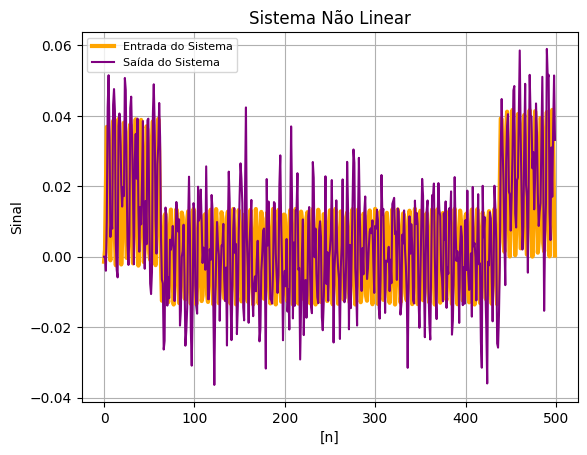

In [4]:
#Gerando dados para teste e validação

x_2 = np.sin(2*n)*np.exp(-1*n) + np.cos(2*n)*np.exp(-1*n)
x_2 = np.sin(1*n)
k_1 = np.ones(N//4)/(N//10)

x_2 = np.convolve(x_2,k_1,'same')


h = 0.01
# noise = np.random.normal(0,0.1,N)
# x = 2*np.sin(2*np.pi*0.5*n*h) + 0.5*np.random.randn(N)

# y_2 = f(x_2,h) + noise
y_2 = f(x_2,h)


plt.plot(n, x_2, c = 'orange', label = 'Entrada do Sistema', linewidth = 3)
plt.plot(n, y_2, color = 'purple',label = 'Saída do Sistema')
plt.xlabel('[n]')
plt.ylabel('Sinal')
plt.title('Sistema Não Linear')
plt.grid()
plt.legend(loc='upper left', fontsize = 8)
plt.show()

[-9.99921044e-01 -9.16594291e-01 -8.33267537e-01 -7.49940783e-01
 -6.66614029e-01 -5.83287276e-01 -4.99960522e-01 -4.16633768e-01
 -3.33307015e-01 -2.49980261e-01 -1.66653507e-01 -8.33267537e-02
  1.11022302e-16  8.33267537e-02  1.66653507e-01  2.49980261e-01
  3.33307015e-01  4.16633768e-01  4.99960522e-01  5.83287276e-01
  6.66614029e-01  7.49940783e-01  8.33267537e-01  9.16594291e-01
  9.99921044e-01]


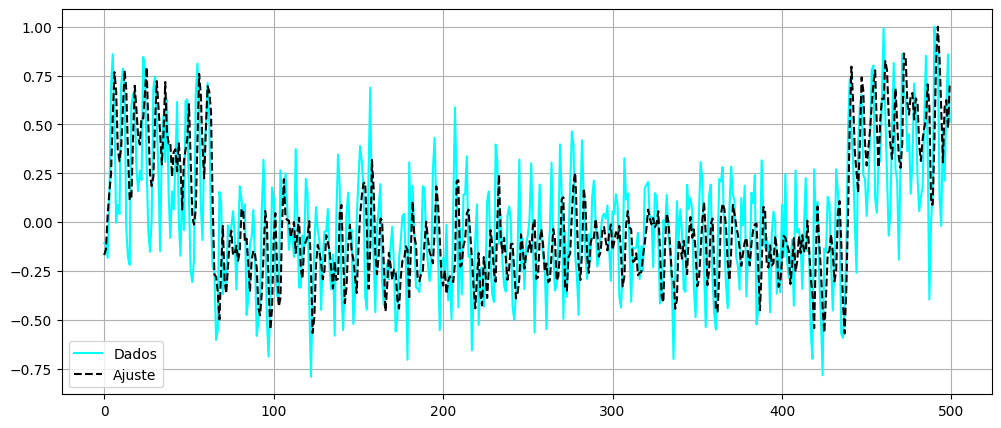

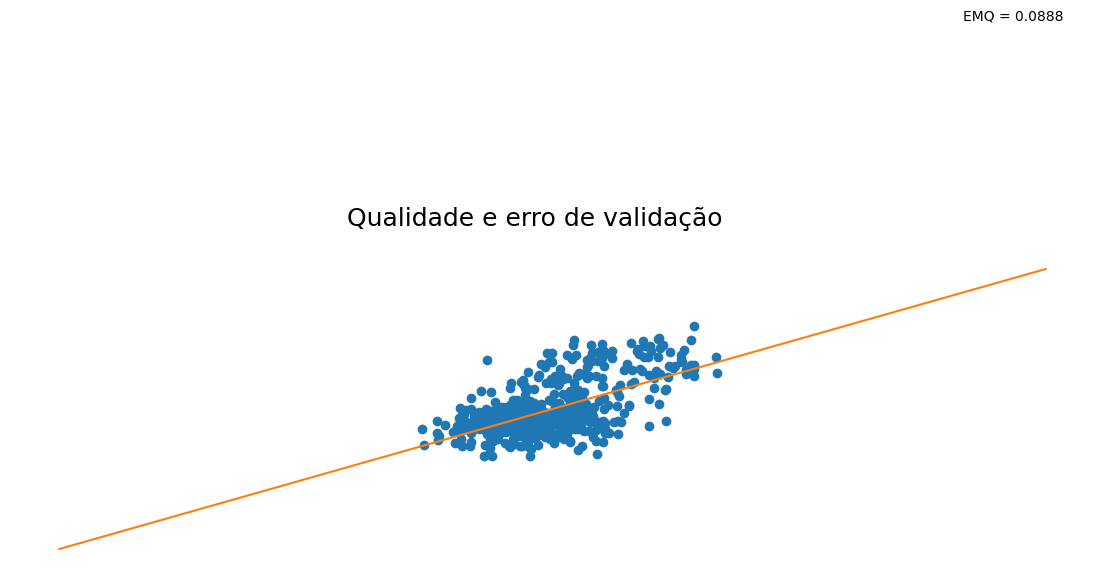

In [5]:
##Validação

# c = np.linspace(0,1,8)  # [0,0.125,0.25,0.375,0.5,0.625,0.75,0.875,1]
M = len(c)
N = len(y_2)
#sigma = 2
print(c)
Y2 = np.array([  np.concatenate((np.zeros(2), y_2[0:-2])),
              np.concatenate((np.zeros(1), y_2[0:-1])) ,
              np.concatenate((np.zeros(2),x_2[0:-2])),
              np.concatenate((np.zeros(1), x_2[0:-1]))  ]).T


U_2 = U_matrix(x_2, y_2, np.array([0]), np.array([1,2]))
Phi2 = Phi(U_2, c, sigma, phi_inv_multiquadrica)


y2_est = Phi2@w

y2_est = y2_est - np.mean(y2_est)
y2_est = y2_est/np.max(np.abs(y2_est))



y_2 = y_2 - np.mean(y_2)
y_2 = y_2/np.max(np.abs(y_2))


EMQ = np.mean((y_2 - y2_est)**2)

p = np.poly1d( np.polyfit(y_2, y2_est, 1) )
t = np.linspace(-3,3,500)






plt.figure(figsize = (12, 5))
plt.plot(y_2,'cyan', label = 'Dados')
plt.plot(y2_est, "--",color = "black", label = 'Ajuste')
plt.legend()
plt.grid()
plt.show()



plt.figure(figsize = (14,4))

plt.suptitle("Qualidade e erro de validação", fontsize=18, y=1)
plt.plot(y_2, y2_est, 'o', t, p(t), '-')
plt.text(2.5, 4.7, 'EMQ = %.4f' %EMQ)
plt.axis('off')
plt.show()

##**Sistema não Linear: Pêndulo**

 Para simular um sistema não linear real, o pêndulo, vamos utilizar a equação física e discretizá-la
 Então a equação física é dada por

 $$
\ddot{\theta}(t) = -\frac{g}{L} sin(\theta(t)) + u(t)
 $$

então fazendo uma substituição de variáveis

 $$
 \begin{cases}
\dot{\theta}(t) = p(t) \\
\dot{p(t)} = -\frac{g}{L} sin(\theta(t)) + u(t)
\end{cases}
 $$

aplicando o método de euler para resolver a equação

 $$
 \begin{cases}
 p(t + \Delta t) = p(t) + \Delta t (-\frac{g}{L} sin(\theta(t)) + u(t))  \\
\theta(t + \Delta t) = \theta(t) + \Delta t \cdot p(t)
 \end{cases}
 $$


 discretizando essa equação, temos

$$
 \begin{cases}
 p[k + 1] = p[k] + h (-\frac{g}{L} sin(\theta[k]) + u[k]) \\
\theta[k+1] = \theta[k] + h \cdot p[k]
 \end{cases}
 $$




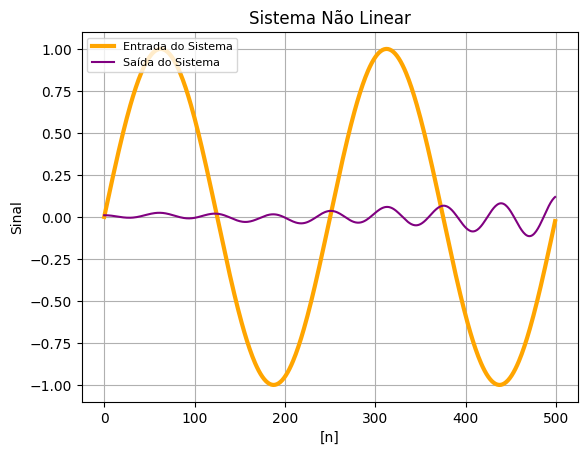

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la



N = 1000//2
n = np.arange(0,N,1)
y = np.zeros(N)

rng = np.random.default_rng(600)
w = rng.normal(0, 1, N)

# filtro FIR simples
h = np.ones(N)/20
# x = np.convolve(w, h, mode='same')

x = np.sin(2*np.pi*n/250)





h = 0.01
noise = np.random.normal(0,0.005,N)
# x = 2*np.sin(2*np.pi*0.5*n*h)*np.exp(-n) + 0.01*np.random.randn(N)

# y_1 = f_pendulo(x,h) + noise
y_1 = f_pendulo(x,h)



plt.plot(n, x, c = 'orange', label = 'Entrada do Sistema', linewidth = 3)
plt.plot(n, y_1, color = 'purple',label = 'Saída do Sistema')
plt.xlabel('[n]')
plt.ylabel('Sinal')
plt.title('Sistema Não Linear')
plt.grid()
plt.legend(loc='upper left', fontsize = 8)
plt.show()


[-9.99921044e-01 -9.16594291e-01 -8.33267537e-01 -7.49940783e-01
 -6.66614029e-01 -5.83287276e-01 -4.99960522e-01 -4.16633768e-01
 -3.33307015e-01 -2.49980261e-01 -1.66653507e-01 -8.33267537e-02
  1.11022302e-16  8.33267537e-02  1.66653507e-01  2.49980261e-01
  3.33307015e-01  4.16633768e-01  4.99960522e-01  5.83287276e-01
  6.66614029e-01  7.49940783e-01  8.33267537e-01  9.16594291e-01
  9.99921044e-01]


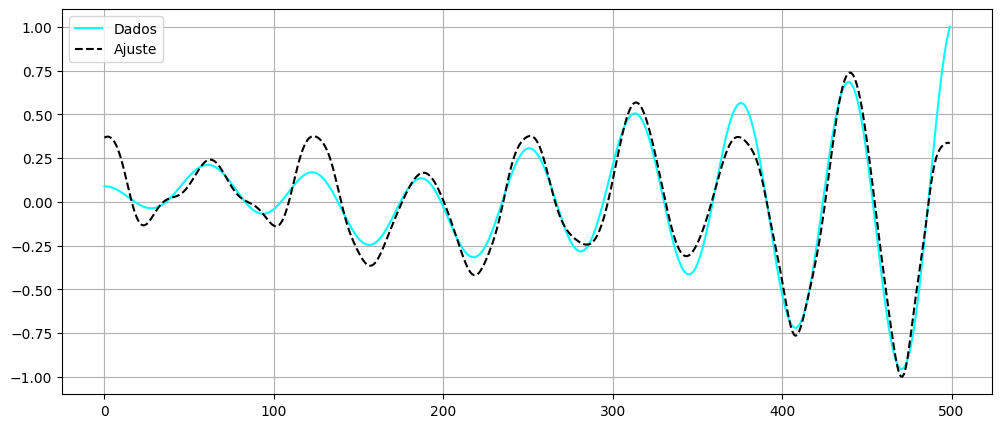

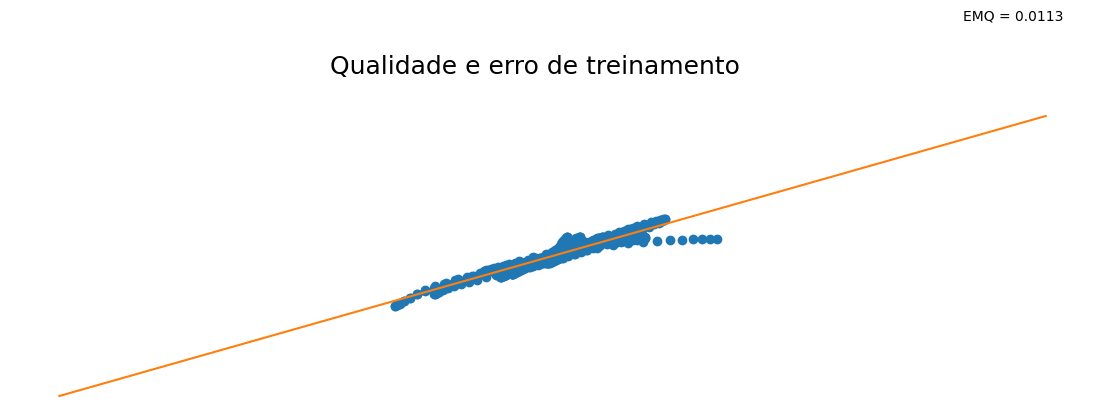

In [7]:
x_1 = x
# c = np.linspace(0,1,8)  # [0,0.125,0.25,0.375,0.5,0.625,0.75,0.875,1]
# c = np.linspace(np.min(y_1),np.max(y_1),50)
M = len(c)
N = len(y_1)
#sigma = 2
print(c)
# sigma = 100*np.ones(M)



U_1 = U_matrix(x_1, y_1, np.array([0]), np.array([1,2]))
Phi1 = Phi(U_1, c, sigma, phi_inv_multiquadrica)



w = np.linalg.inv(Phi1.T@Phi1)@Phi1.T@y_1

y1_est = Phi1@w
y1_est = y1_est - np.mean(y1_est)
y1_est = y1_est/np.max(np.abs(y1_est))

y_1 = y_1 - np.mean(y_1)
y_1 = y_1/np.max(np.abs(y_1))


plt.figure(figsize = (12, 5))
plt.plot(y_1,'cyan', label = 'Dados')
plt.plot(y1_est, "--",color = "black", label = 'Ajuste')
plt.legend()
plt.grid()
plt.show()

EMQ = np.mean((y_1 - y1_est)**2)

p = np.poly1d( np.polyfit(y_1, y1_est, 1) )
t = np.linspace(-3,3,500)

plt.figure(figsize = (14,4))

plt.suptitle("Qualidade e erro de treinamento", fontsize=18, y=1)
plt.plot(y_1, y1_est, 'o', t, p(t), '-')
plt.text(2.5, 4.7, 'EMQ = %.4f' %EMQ)
plt.axis('off')
plt.show()

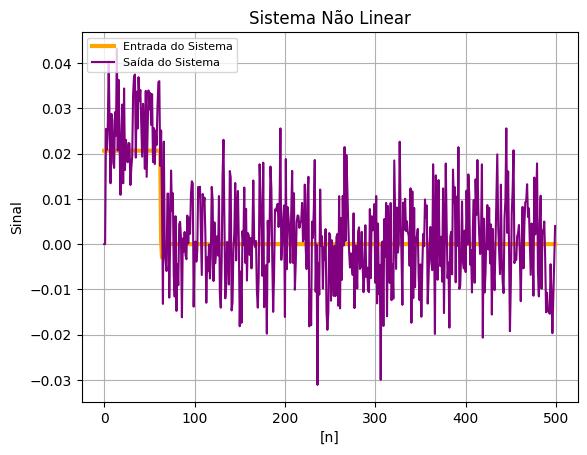

In [8]:
#Gerando dados para teste e validação

x_2 = np.sin(2*n)*np.exp(-1*n) + np.cos(2*n)*np.exp(-1*n)
# x_2 = np.sin(1*n)
k_1 = np.ones(N//4)/(N//10)

x_2 = np.convolve(x_2,k_1,'same')


h = 0.01
# noise = np.random.normal(0,0.1,N)
# x = 2*np.sin(2*np.pi*0.5*n*h) + 0.5*np.random.randn(N)

# y_2 = f(x_2,h) + noise
y_2 = f(x_2,h)


plt.plot(n, x_2, c = 'orange', label = 'Entrada do Sistema', linewidth = 3)
plt.plot(n, y_2, color = 'purple',label = 'Saída do Sistema')
plt.xlabel('[n]')
plt.ylabel('Sinal')
plt.title('Sistema Não Linear')
plt.grid()
plt.legend(loc='upper left', fontsize = 8)
plt.show()

[-9.99921044e-01 -9.16594291e-01 -8.33267537e-01 -7.49940783e-01
 -6.66614029e-01 -5.83287276e-01 -4.99960522e-01 -4.16633768e-01
 -3.33307015e-01 -2.49980261e-01 -1.66653507e-01 -8.33267537e-02
  1.11022302e-16  8.33267537e-02  1.66653507e-01  2.49980261e-01
  3.33307015e-01  4.16633768e-01  4.99960522e-01  5.83287276e-01
  6.66614029e-01  7.49940783e-01  8.33267537e-01  9.16594291e-01
  9.99921044e-01]


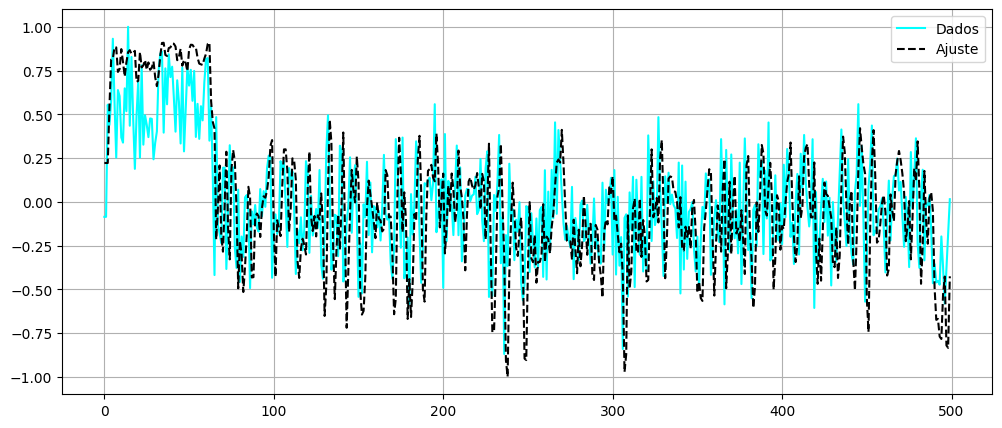

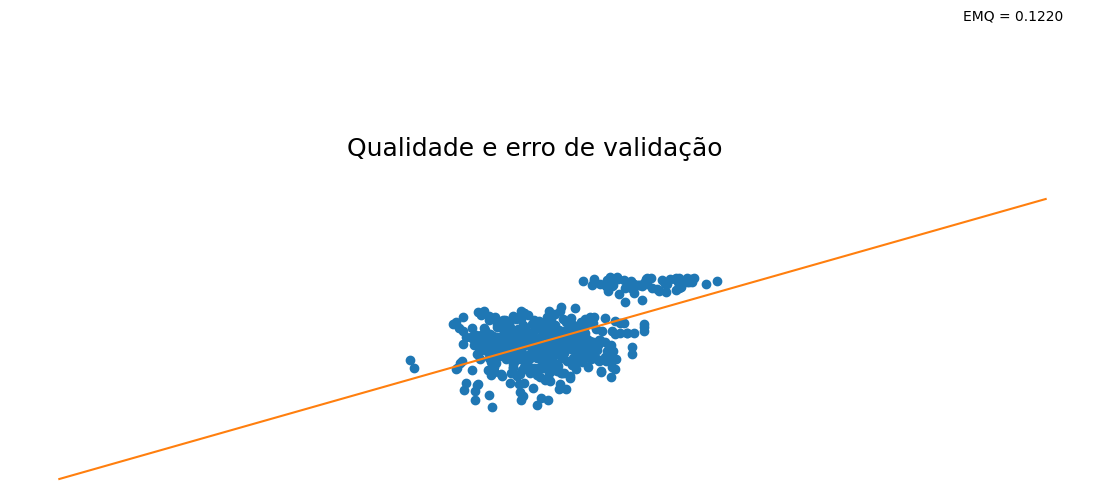

In [9]:
##Validação

# c = np.linspace(0,1,8)  # [0,0.125,0.25,0.375,0.5,0.625,0.75,0.875,1]
M = len(c)
N = len(y_2)
#sigma = 2
print(c)
U_2 = U_matrix(x_2, y_2, np.array([0]), np.array([1,2]))
Phi2 = Phi(U_2, c, sigma, phi_inv_multiquadrica)


y2_est = Phi2@w

y2_est = y2_est - np.mean(y2_est)
y2_est = y2_est/np.max(np.abs(y2_est))



y_2 = y_2 - np.mean(y_2)
y_2 = y_2/np.max(np.abs(y_2))


EMQ = np.mean((y_2 - y2_est)**2)

p = np.poly1d( np.polyfit(y_2, y2_est, 1) )
t = np.linspace(-3,3,500)






plt.figure(figsize = (12, 5))
plt.plot(y_2,'cyan', label = 'Dados')
plt.plot(y2_est, "--",color = "black", label = 'Ajuste')
plt.legend()
plt.grid()
plt.show()



plt.figure(figsize = (14,4))

plt.suptitle("Qualidade e erro de validação", fontsize=18, y=1)
plt.plot(y_2, y2_est, 'o', t, p(t), '-')
plt.text(2.5, 4.7, 'EMQ = %.4f' %EMQ)
plt.axis('off')
plt.show()

##**Sistema não Linear: Motor DC No Tinkercad**
Para simular com um dado quase real, vamos simular a resposta de um motor DC no tinkercad e verificar se a nossa rede consegue aprender a dinâmica de um sistema real, assim, vamos definir a entrada como sendo um valor de PWM, e a saída a velocidade do motor em tempo real.





##**Referências**
[1]
Jurnal Teknologi, 36(A) Jun. 2002: 39–54
© Universiti Teknologi Malaysia
RADIAL BASIS FUNCTION (RBF) FOR NON-LINEAR DYNAMIC
SYSTEM IDENTIFICATION
ROBIAH AHMAD1
 & HISHAMUDDIN JAMALUDDIN2

[2] The Matrix Cookbook
[ http://matrixcookbook.com ]
Kaare Brandt Petersen
Michael Syskind Pedersen
Version: November 15, 2012